# <ins>Predicting Poetic Movements</ins>

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Baseline model (Naive Bayes)](#Baseline-model-(Naive-Bayes))
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)
        - [Doc2Vec](#Doc2Vec)
        - [Word2Vec](#Word2Vec)
        - [Combining document and word vectors](#Combining-document-and-word-vectors)
        - [Parameter tuning](#Parameter-tuning)
        - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

In this notebook, I will create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [225]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec, KeyedVectors

# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

# miscellany
import os
import time
from tqdm import tqdm
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [4]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Multicollinearity

[[go back to the top](#Predicting-Poetic-Movements)]

In [5]:
# list of continuous variables
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

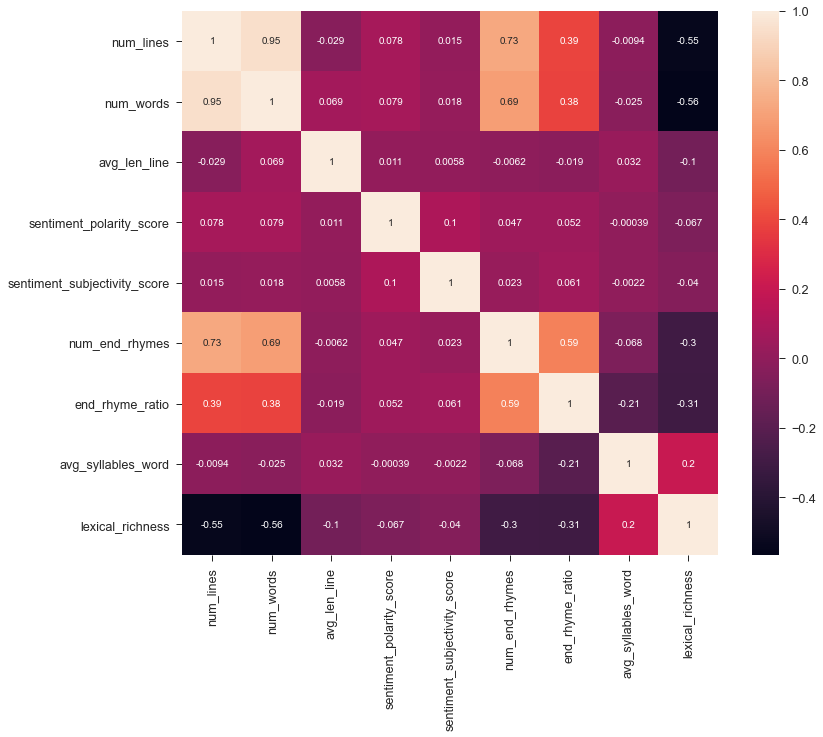

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- As seen in the [previous notebook](03_nlp_features_eda.ipynb), the number of lines (```num_lines```) and number of words (```num_words```) in a poem are very highly correlated.
    - I'll drop ```num_words```, as the number of lines is a more widely used metric for the length of a poem.
- The number of end rhymes (```num_end_rhymes```) is also rather highly correlated with ```num_lines```, so it's worth considering dropping that.
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [7]:
# new list of continuous variables
cont_cols = [
    'num_lines', 'avg_len_line', 'sentiment_polarity_score', 
    'sentiment_subjectivity_score', 'end_rhyme_ratio', 
    'avg_syllables_word', 'lexical_richness'
]

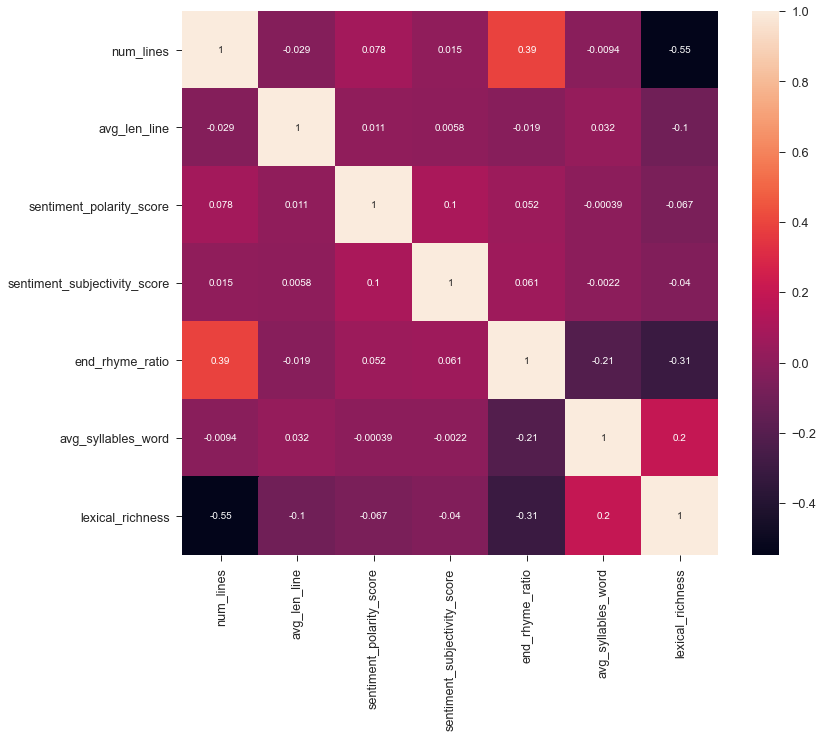

In [8]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Predicting-Poetic-Movements)]

- Cap or floor outlier values as necessary.

In [9]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [10]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_lines                       7.000000
avg_len_line                    3.346818
sentiment_polarity_score       -0.970270
sentiment_subjectivity_score    0.257885
end_rhyme_ratio                 0.000000
avg_syllables_word              1.092393
lexical_richness                0.440678
Name: 0.05, dtype: float64
------------------------------------------
num_lines                       131.700000
avg_len_line                      9.750000
sentiment_polarity_score          0.995900
sentiment_subjectivity_score      0.687500
end_rhyme_ratio                   1.009091
avg_syllables_word                1.372212
lexical_richness                  0.850402
Name: 0.95, dtype: float64


#### Number of lines

In [11]:
# descriptive stats
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

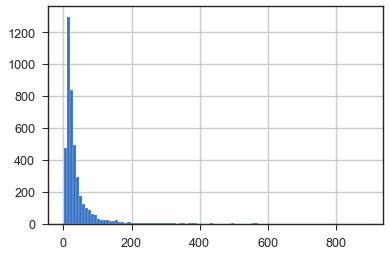

In [12]:
# current distribution
df.num_lines.hist(bins=100);

In [13]:
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])

# descriptive stats
df_capped['num_lines'].describe()

count    4307.000000
mean       34.295147
std        31.983861
min         7.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       131.700000
Name: num_lines, dtype: float64

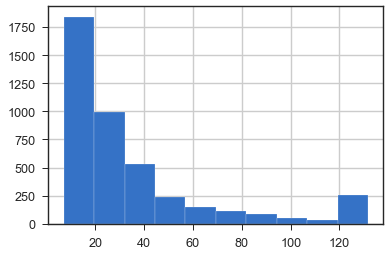

In [14]:
# new distribution
df_capped.num_lines.hist();

#### Average words per line

In [15]:
# descriptive stats
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

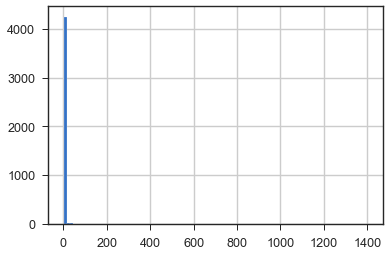

In [16]:
# current distribution
df.avg_len_line.hist(bins=100);

In [17]:
# cap/floor outliers
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])

# descriptive stats
df_capped['avg_len_line'].describe()

count    4307.000000
mean        6.494119
std         1.721049
min         3.346818
25%         5.260870
50%         6.527778
75%         7.714286
max         9.750000
Name: avg_len_line, dtype: float64

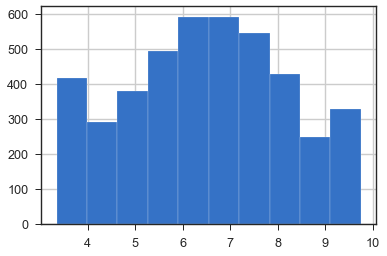

In [18]:
# new distribution
df_capped.avg_len_line.hist();

#### End rhyme ratio

In [19]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

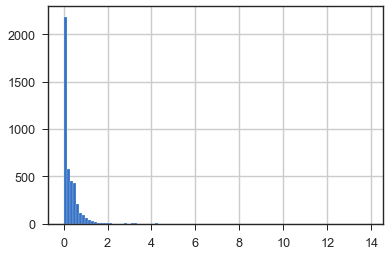

In [20]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [21]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4307.000000
mean        0.254074
std         0.293332
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max         1.009091
Name: end_rhyme_ratio, dtype: float64

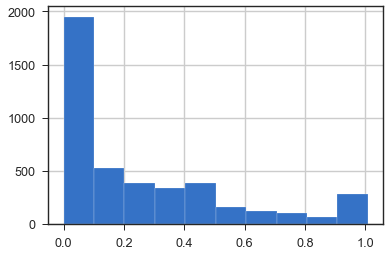

In [22]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [23]:
# descriptive stats
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

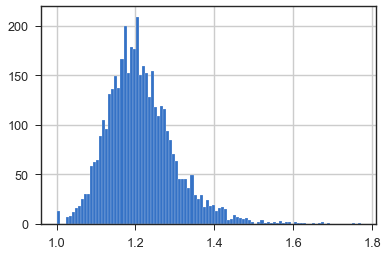

In [24]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [25]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4307.000000
mean        1.212364
std         0.075228
min         1.092393
25%         1.155752
50%         1.204545
75%         1.261905
max         1.372212
Name: avg_syllables_word, dtype: float64

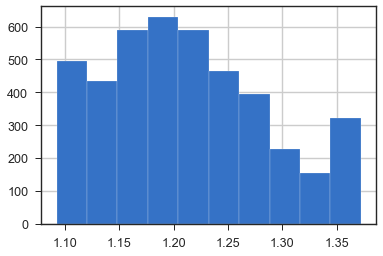

In [26]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [27]:
# descriptive stats
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

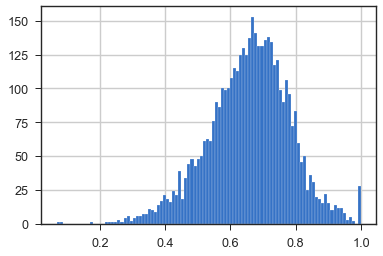

In [28]:
# current distribution
df.lexical_richness.hist(bins=100);

In [29]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4307.000000
mean        0.658047
std         0.111326
min         0.440678
25%         0.580302
50%         0.666667
75%         0.740260
max         0.850402
Name: lexical_richness, dtype: float64

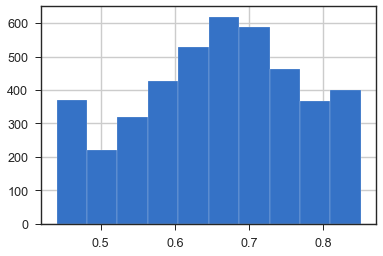

In [30]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [31]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

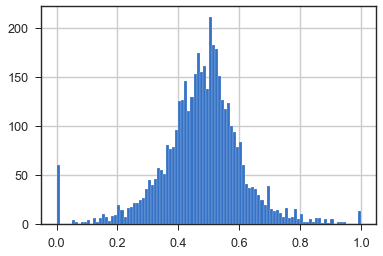

In [32]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [33]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4307.000000
mean        0.479417
std         0.109112
min         0.257885
25%         0.410284
50%         0.484470
75%         0.550000
max         0.687500
Name: sentiment_subjectivity_score, dtype: float64

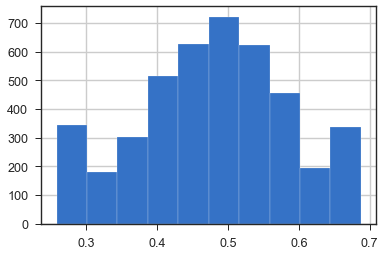

In [34]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [35]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df_capped.pkl', 'wb') as goodbye:
#     pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
#     df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Predicting-Poetic-Movements)]

- Create features DataFrame and target series.
    - While removing stop words was helpful for EDA in the [previous notebook](#03_nlp_features_eda.ipynb#Step-4:-Natural-language-processing), I'll refrain from doing that here, which should result in more accurate models. Using a TF-IDF vectorizer renders frequent words (i.e. words generally among the stop words list) less relevant.
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    - Vectorize using a TF-IDF vectorizer.
    
#### Features and target

In [36]:
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness']
]

# assign target variable
y = df_capped['movement']

In [37]:
# lowercase text without punctuation and contractions
X['string_processed'] = df_capped.string_titled.apply(simple_process)

In [132]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [39]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_processed')
X_test_nums = X_test.drop(columns='string_processed')

In [40]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [41]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_processed)
X_test_vec_matrix = vectorizer.transform(X_test.string_processed)

CPU times: user 748 ms, sys: 10.9 ms, total: 759 ms
Wall time: 759 ms


In [42]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 21.9 s, sys: 73.3 ms, total: 21.9 s
Wall time: 21.9 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [43]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

# Step 2: Modeling

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters on the best model.
- Finally, I can train and save a final model.

## Baseline model (Naive Bayes)

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [44]:
%%time

# instantiate the naive bayes classifier
benaba_vec = BernoulliNB()

# fit it to training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 5.53 s, sys: 790 ms, total: 6.32 s
Wall time: 5.85 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [227]:
%%time

# model predictions and printout
train_preds_bnb_vec, test_preds_bnb_vec = \
    predict(benaba_vec, X_train_vec, y_train, 
            X_test_vec, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6713713631652958

-----TEST-----
Accuracy: 0.4568245125348189
F1 score: 0.4270771658947016

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.77      0.13      0.22       239
metropolitan       0.67      0.35      0.46       268
      modern       0.36      0.86      0.50       311
 avant_garde       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.61      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 30  31 171   7]
 [  7  94 160   7]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 8.44 s, sys: 1.11 s, total: 9.55 s
Wall time: 8.54 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [46]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
aa, nikes, nihilist, nihil, nighty, nightwoods, nightwatchmans, nightsong, nightmares, nightmard

Avant-Garde tweets:
aa, modesty, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds

Modern tweets:
lenin, hd, scratchy, hazels, hazelnut, hazel, hazed, hazards, screamd, hazarded

Pre-1900 tweets:
lenin, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

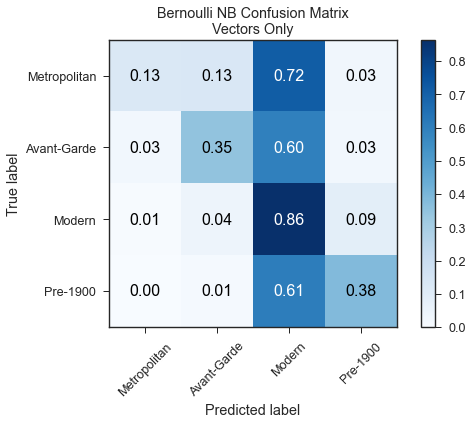

In [47]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_vec)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,                   
    title='Bernoulli NB Confusion Matrix\nVectors Only', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [48]:
%%time

# instantiate the naive bayes classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 12.4 s, sys: 2.48 s, total: 14.9 s
Wall time: 14.6 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [228]:
%%time

# model predictions and printout
train_preds_bnb_combo, test_preds_bnb_combo = \
    predict(benaba_combo, X_train_combo, y_train, 
            X_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.6684210526315789
F1 score: 0.6751999282476966

-----TEST-----
Accuracy: 0.4586815227483751
F1 score: 0.4296462820371316

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.74      0.13      0.22       239
metropolitan       0.66      0.35      0.46       268
      modern       0.36      0.86      0.51       311
 avant_garde       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.60      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 31  32 169   7]
 [  9  95 158   6]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 15.9 s, sys: 3.16 s, total: 19 s
Wall time: 18.2 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

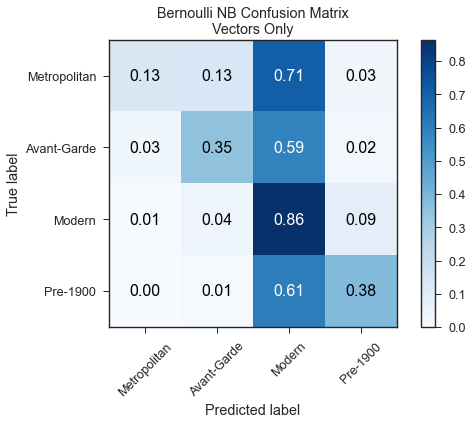

In [50]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_bnb_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Bernoulli NB Confusion Matrix\nVectors Only', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This confirms it is practically the same, with a slightly better accuracy at predicting Metropolitan.

#### Feature importances

In [51]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
zz, slackend, impending, impend, impels, slackened, impediment, impedes, slackening, impede

Avant-Garde tweets:
lengthwise, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds, mockingbird

Modern tweets:
lengthwise, hazel, hazed, hazards, scraping, hazarded, scrappy, hazan, hayworth, haystraw

Pre-1900 tweets:
lengthwise, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: The next cell took me about three minutes to run.

In [52]:
%%time

# instantiate decision tree classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

# fit them to the training set and evaluate
cv_scores_knn_vec = cross_val_score(
    knn_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_knn_combo = cross_val_score(
    knn_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_knn_vec}')
print(f'Average score: {np.mean(cv_scores_knn_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_knn_combo}')
print(f'Average score: {np.mean(cv_scores_knn_combo)}\n')

-----Vectors only-----
All scores: [0.34081473 0.32791069 0.37598843 0.33418527 0.32975972 0.32500524
 0.31292064 0.36944109 0.35442761 0.33124332]
Average score: 0.3401696752712211

------Vectors + Numerical Data-----
All scores: [0.50270974 0.52729918 0.55621674 0.56323718 0.53661691 0.48830611
 0.53023397 0.55724183 0.55134632 0.53379778]
Average score: 0.5347005761956732

CPU times: user 5min 23s, sys: 12.8 s, total: 5min 36s
Wall time: 13min 32s


- This performs better than the Naive Bayes model, and the combo data set is far better than vectors only.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

⏰ NOTE: The next cell took me over 40 minutes to run.

100%|██████████| 25/25 [35:47<00:00, 85.90s/it]


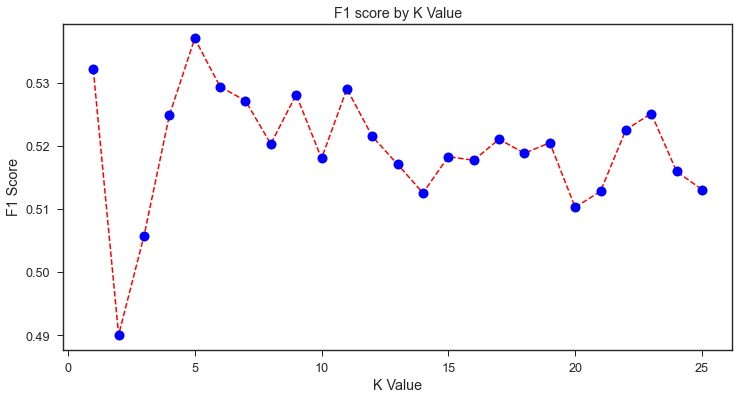

CPU times: user 3h 25min 58s, sys: 1min 31s, total: 3h 27min 30s
Wall time: 35min 47s


In [53]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
k_range = list(range(1, 26))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [54]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(5, 0.537095723460491),
 (1, 0.5321888160863517),
 (6, 0.5294555875763667),
 (11, 0.5291090099029194),
 (9, 0.5281936024573077)]

- *k=5* appears to have the best results, so I'll train a model on that.

In [55]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=5, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 18.6 s, sys: 2.02 s, total: 20.6 s
Wall time: 20.6 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

⏰ NOTE: The next cell took me about 5 minutes to run.

In [229]:
%%time

# model predictions and printout
train_preds_knn_combo, test_preds_knn_combo = \
    predict(knn_combo, X_train_combo, y_train, 
            X_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.7018575851393188
F1 score: 0.6998579791649526

-----TEST-----
Accuracy: 0.542246982358403
F1 score: 0.537095723460491

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.48      0.64      0.55       239
metropolitan       0.48      0.49      0.49       268
      modern       0.52      0.38      0.44       311
 avant_garde       0.68      0.71      0.70       259

    accuracy                           0.54      1077
   macro avg       0.54      0.55      0.54      1077
weighted avg       0.54      0.54      0.54      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[152  51  26  10]
 [ 82 131  40  15]
 [ 64  70 117  60]
 [ 16  19  40 184]]
CPU times: user 31min 29s, sys: 11.3 s, total: 31min 40s
Wall time: 5min 3s


#### Confusion matrix

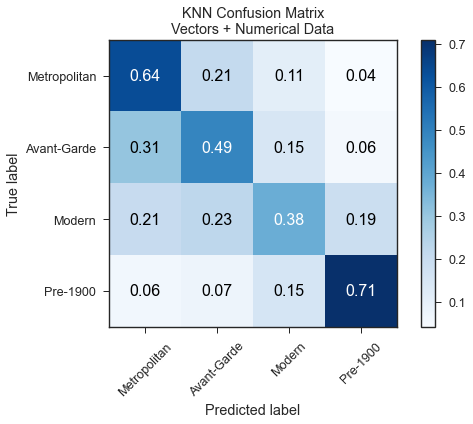

In [57]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_knn_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='KNN Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/knn_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Metropolitan, which is interesting. Perhaps this genre is quite clustered.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Modern and Avant-Garde.
    
- Pretty overfit.

## Decision Tree

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: The next cell took me about 7 minutes to run.

In [58]:
%%time

# instantiate decision tree classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

# fit them to the training set and evaluate
cv_scores_tree_vec = cross_val_score(
    tree_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_tree_combo = cross_val_score(
    tree_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_tree_vec}')
print(f'Average score: {np.mean(cv_scores_tree_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_tree_combo}')
print(f'Average score: {np.mean(cv_scores_tree_combo)}\n')

-----Vectors only-----
All scores: [0.3890447  0.42945591 0.41999391 0.37878863 0.42808923 0.34437756
 0.3836402  0.3873701  0.41115727 0.39809083]
Average score: 0.3970008320790465

------Vectors + Numerical Data-----
All scores: [0.42065061 0.45398715 0.44785858 0.48154491 0.50314441 0.47777335
 0.51468983 0.48365028 0.49560617 0.45666732]
Average score: 0.4735572610148614

CPU times: user 4min 1s, sys: 3.76 s, total: 4min 5s
Wall time: 5min 23s


- A Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain those using Random Forest, however.

## Random Forest

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

⏰ NOTE: The next cell took me about 9 minutes to run.

In [59]:
%%time

# instantiate random forest classifiers
forest_vec = RandomForestClassifier()
forest_combo = RandomForestClassifier()

# fit them to the training set and evaluate
cv_scores_forest_vec = cross_val_score(
    forest_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_forest_combo = cross_val_score(
    forest_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_forest_vec}')
print(f'Average score: {np.mean(cv_scores_forest_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_forest_combo}')
print(f'Average score: {np.mean(cv_scores_forest_combo)}\n')

-----Vectors only-----
All scores: [0.5184807  0.59157714 0.5481667  0.57836064 0.5741709  0.47811782
 0.56476    0.53854635 0.59940483 0.51292361]
Average score: 0.5504508695393581

------Vectors + Numerical Data-----
All scores: [0.55487995 0.6730177  0.63655937 0.62859177 0.60784858 0.58686058
 0.62440351 0.59052678 0.63563978 0.57609618]
Average score: 0.6114424217891324

CPU times: user 4min 19s, sys: 3.44 s, total: 4min 22s
Wall time: 6min 4s


- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [60]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 21.4 s, sys: 1.45 s, total: 22.8 s
Wall time: 22.8 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [230]:
%%time

# model predictions and printout
train_preds_forest_combo, test_preds_forest_combo = \
    predict(forest_combo, X_train_combo, y_train, 
            X_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.5933147632311978
F1 score: 0.592403359522887

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.57      0.47      0.52       239
metropolitan       0.57      0.47      0.51       268
      modern       0.50      0.67      0.57       311
 avant_garde       0.79      0.74      0.77       259

    accuracy                           0.59      1077
   macro avg       0.61      0.59      0.59      1077
weighted avg       0.60      0.59      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[113  53  68   5]
 [ 48 125  85  10]
 [ 36  31 209  35]
 [  2   9  56 192]]
CPU times: user 12.7 s, sys: 2.81 s, total: 15.5 s
Wall time: 15.8 s


#### Confusion matrix

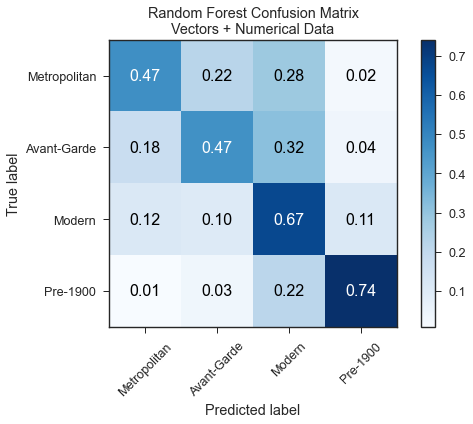

In [62]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_forest_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Random Forest Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rf_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Much better overall F1 score, but I'm back to overpredicting Modern.
- Unlike KNN, however, this is very overfit, so tuning this would definitely be necessary.
- Still, this will be a great model to use to look at important features.

#### Feature importances

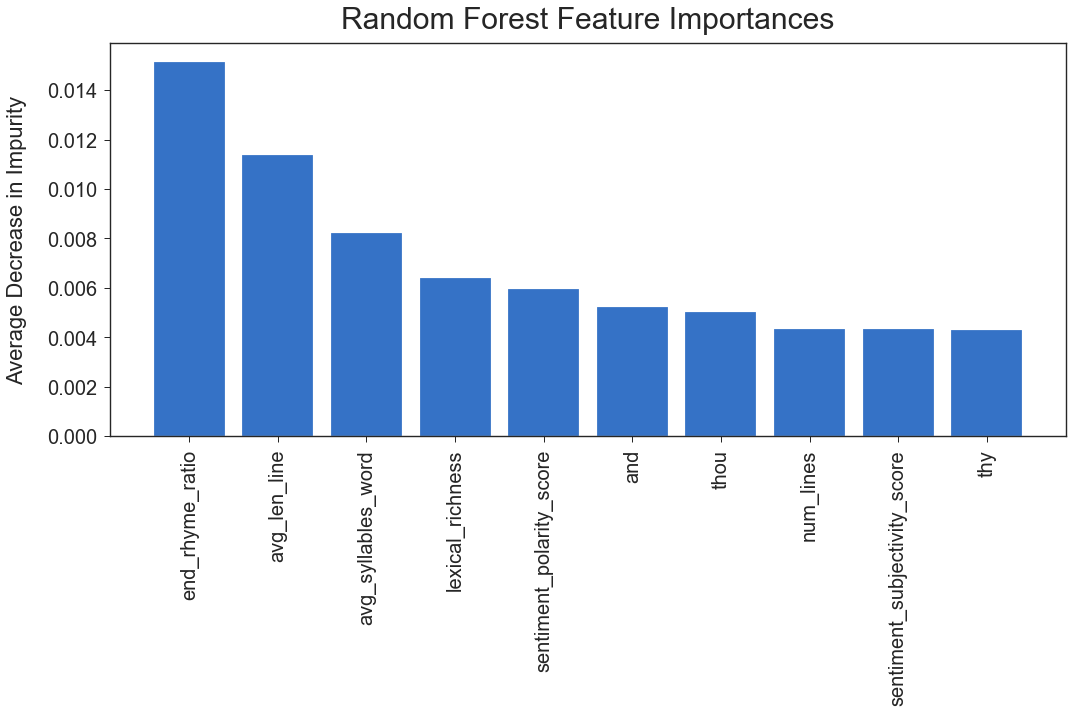





[('end_rhyme_ratio', 0.01513269871718084), ('avg_len_line', 0.011356006587025416), ('avg_syllables_word', 0.008207915476957758), ('lexical_richness', 0.0063850099869278525), ('sentiment_polarity_score', 0.005968426331171708), ('and', 0.005212066615805195), ('thou', 0.0050384785067620706), ('num_lines', 0.004322734479828278), ('sentiment_subjectivity_score', 0.004322129583883042), ('thy', 0.004285908048344382)]


In [63]:
# top 10 features
plot_forest_features(
    forest_combo, 
    X_train_combo)

- Mostly engineered features here, with the ratio of end rhymes to total lines have a large importance compared to the rest.
- Also, some interesting words.
    - *And* is a bit of a mystery as AH SHIT.
    - *Heart* only appears in the top 25 words for Pre-1900 poetry.
    - *Love* is the second most used word (after processing), and appears in the top 25 of all classes.

## SVM

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: Next cell took me 10 minutes to run.

In [64]:
%%time

# instantiate svm classifiers
svm_vec = LinearSVC()
svm_combo = LinearSVC()

# fit them to the training set and evaluate
cv_scores_svm_vec = cross_val_score(
    svm_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_combo = cross_val_score(
    svm_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_vec}')
print(f'Average score: {np.mean(cv_scores_svm_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_combo}')
print(f'Average score: {np.mean(cv_scores_svm_combo)}\n')

-----Vectors only-----
All scores: [0.62761568 0.71386136 0.59946969 0.64340131 0.65450934 0.66156892
 0.58829792 0.61299607 0.65410261 0.60955467]
Average score: 0.636537757851741

------Vectors + Numerical Data-----
All scores: [0.65097901 0.70820609 0.64683284 0.68607899 0.65457732 0.67129181
 0.66054012 0.67212663 0.72090737 0.63698163]
Average score: 0.6708521793164735

CPU times: user 4min 17s, sys: 4.48 s, total: 4min 22s
Wall time: 6min 31s


- This is the best one yet! And I'm not surprised. SVM tends to work well with text classification and data that has fewer data points and lots of variables (i.e. word vectors).
- Once again, my engineered features seem to help out the model, so I'll train a basic one here. Then I can focus on tuning parameters.

### Vectors + numerical data

In [65]:
%%time

# instantiate the model
svm_combo = LinearSVC(random_state=1)

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 45.2 s, sys: 1.99 s, total: 47.2 s
Wall time: 47.2 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [231]:
%%time

# model predictions and printout
train_preds_svm_combo, test_preds_svm_combo = \
    predict(svm_combo, X_train_combo, y_train, 
            X_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.9990712074303405
F1 score: 0.9990713532528626

-----TEST-----
Accuracy: 0.6564531104921077
F1 score: 0.6552542692291389

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.60      0.65      0.62       239
metropolitan       0.60      0.60      0.60       268
      modern       0.61      0.56      0.59       311
 avant_garde       0.81      0.84      0.83       259

    accuracy                           0.66      1077
   macro avg       0.66      0.66      0.66      1077
weighted avg       0.66      0.66      0.66      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[155  43  34   7]
 [ 50 160  50   8]
 [ 47  54 175  35]
 [  5  11  26 217]]
CPU times: user 11 s, sys: 2.24 s, total: 13.2 s
Wall time: 12.2 s


#### Confusion matrix

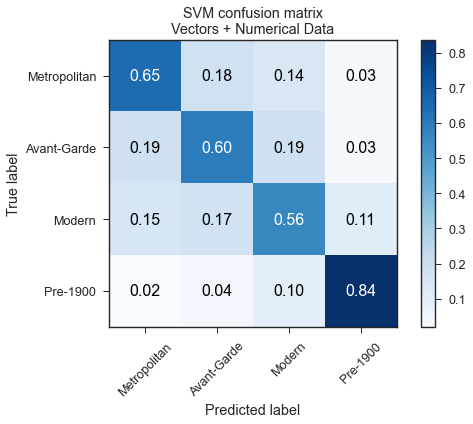

In [67]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_combo_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Still overfit but a very good spread of predictions here compared to the other models.
    - Each category is correctly predicted at least half the time.
- Pre-1900 poetry is very easily recognized by the model.
    - Modern poetry appears to be the largest confusing factor here, so must share some similarities. 
    - Avant-Garde and Metropolitan are hardly ever predicted for Pre-1900 poems and Pre-1900 is hardly predicted for Metropolitan and Avant-Garde poems.
- As in the KNN, Metropolitan has seen quite a boost, whereas Avant-Garde and Modern seem a little more difficult to correctly predict.

#### Feature importances

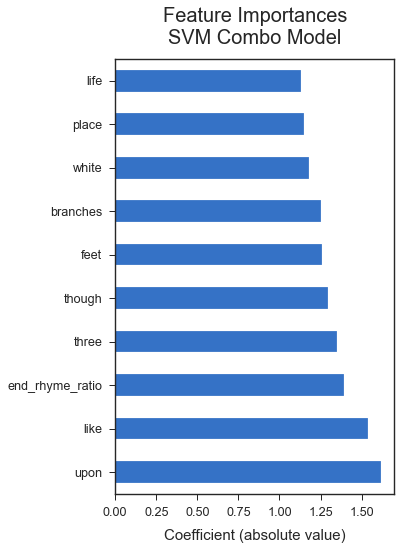

In [68]:
svm_features(svm_combo, X_train_combo.columns)

- Only the ratio of end rhymes to total lines made it from my engineered features. 
- Mostly surprising words, *white* being the only word in the top 25 overall.

## Doc2Vec

[[go back to the top](#Predicting-Poetic-Movements)]

### Preparing the data
- Instead of using the MinMaxScaler, I'll rescale my engineered features using StandardScaler, since the document vectors appear to be more along that scale.
- Then I'll split the poems into a training and a testing corpus and create TaggedDocument objects needed by Doc2Vec, using only the training data.

In [69]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [70]:
train_data = [poem.split() for poem in X_train.string_processed]
test_data = [poem.split() for poem in X_test.string_processed]

# prepare training data in doc2vec format
train_docs = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]

In [71]:
# %%time

# model_scores = []

# for i in tqdm(range(1,10)):
#     # train a doc2vec model to learn tweet representations. Use only training data!!
#     model = Doc2Vec(vector_size=100, alpha=0.025, min_count=i, dm=1, epochs=100)
#     model.build_vocab(train_docs)
#     model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)
    
#     # infer in multiple steps to get a stable representation. 
#     train_vecs = [model.infer_vector(words, epochs=100) for words in train_data]
#     test_vecs = [model.infer_vector(words, epochs=100) for words in test_data]
    
#     doc_train_vecs = pd.DataFrame(train_vecs, columns=[f'docvec_{i}' for i in range(100)])
#     doc_test_vecs = pd.DataFrame(test_vecs, columns=[f'docvec_{i}' for i in range(100)])
    
#     doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs], axis=1)
#     doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs], axis=1)
    
#     # instantiate the model
#     svm_doc_combo = LinearSVC(random_state=1)

#     # fit them to the training set and evaluate
#     cv_scores_svm_doc_combo = cross_val_score(
#         svm_doc_combo, doc_train_combo, y_train, 
#         scoring='f1_weighted', cv=10, n_jobs=-1
#     )

#     model_scores.append(np.mean(cv_scores_svm_doc_combo))

### Training a model
- I'll train the model on the training data and create vectors using the model for *both* the train set and the test set, which tends to prevent overfitting.
- After combining with my engineered features, I'll cross validate and train a model.

*NOTE: Much of this code is based on O'Reilly's* [Practical NLP](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/02_Doc2Vec_Example.ipynb).

In [72]:
%%time

# train a doc2vec model, using only training data
model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=6,
                dm=1, epochs=100)

model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

# save the model
model.save('data/d2v.model')

CPU times: user 2min, sys: 3.24 s, total: 2min 4s
Wall time: 55.1 s


In [73]:
%%time

model = Doc2Vec.load('data/d2v.model')

# infer in multiple steps to get a stable representation. 
train_vecs = [model.infer_vector(words, epochs=100) for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) for words in test_data]

CPU times: user 1min 43s, sys: 165 ms, total: 1min 43s
Wall time: 1min 43s


In [74]:
# convert to dataframe
doc_train_vecs = pd.DataFrame(train_vecs, columns=[f'docvec_{i}' for i in range(1,101)])
doc_test_vecs = pd.DataFrame(test_vecs, columns=[f'docvec_{i}' for i in range(1,101)])

In [75]:
# combine with engineered features
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs], axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs], axis=1)

# confirm good shape
doc_train_combo.shape, doc_test_combo.shape

((3230, 107), (1077, 107))

In [76]:
%%time

# instantiate svm classifiers
svm_doc_vec = LinearSVC(random_state=1)
svm_doc_combo = LinearSVC(random_state=1)

# fit them to the training set and evaluate
cv_scores_svm_doc_vec = cross_val_score(
    svm_doc_vec, doc_train_vecs, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_doc_combo = cross_val_score(
    svm_doc_combo, doc_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_doc_vec}')
print(f'Average score: {np.mean(cv_scores_svm_doc_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_doc_combo}')
print(f'Average score: {np.mean(cv_scores_svm_doc_combo)}\n')

-----Vectors only-----
All scores: [0.53172398 0.64415139 0.54012914 0.52463792 0.60675256 0.56196432
 0.54941699 0.60275348 0.57544037 0.55559306]
Average score: 0.5692563203512139

------Vectors + Numerical Data-----
All scores: [0.58266756 0.64926219 0.56756464 0.63123497 0.6303145  0.61599665
 0.65648521 0.63579857 0.63544561 0.64759865]
Average score: 0.6252368551517893

CPU times: user 92.4 ms, sys: 33.5 ms, total: 126 ms
Wall time: 15.6 s


- Once again, the combination of vectors and engineered features provides better F1 scores.

In [77]:
%%time

# instantiate the model
svm_doc = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_doc.fit(doc_train_combo, y_train)

CPU times: user 2.63 s, sys: 4.79 ms, total: 2.63 s
Wall time: 2.63 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [232]:
%%time

# model predictions and printout
train_preds_svm_doc, test_preds_svm_doc = \
    predict(svm_doc, doc_train_combo, y_train, 
            doc_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.6724458204334365
F1 score: 0.6693021517506966

-----TEST-----
Accuracy: 0.6239554317548747
F1 score: 0.6160533190481263

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.57      0.51      0.54       239
metropolitan       0.55      0.64      0.59       268
      modern       0.60      0.47      0.53       311
 avant_garde       0.75      0.90      0.82       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  70  36  10]
 [ 44 171  42  11]
 [ 47  61 146  57]
 [  2   7  18 232]]
CPU times: user 271 ms, sys: 53.6 ms, total: 325 ms
Wall time: 89 ms


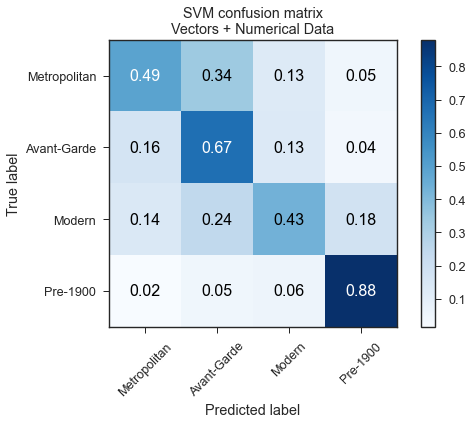

In [79]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_doc)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Interestingly tends to overpredict on Avant-Garde and has a difficult time correctly identifying Modern poetry.
- Incredible score for Pre-1900 poetry.



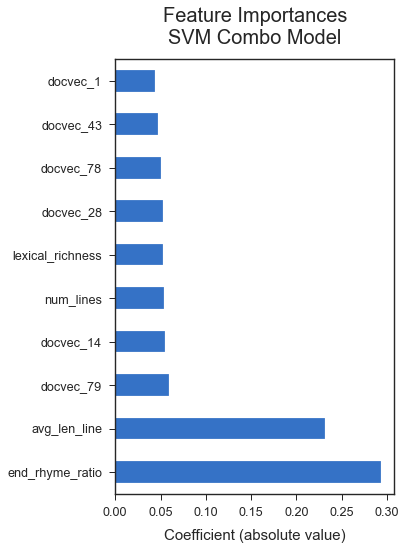

In [215]:
# plot top ten features
svm_features(svm_doc, doc_train_combo.columns)

## Word2Vec

[[go back to the top](#Predicting-Poetic-Movements)]

### Preparing the data
- I'll be using pre-trained GloVe vectors.

*NOTE: Much of this code is based on O'Reilly's* [Practical NLP](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/03_Word2Vec_Example.ipynb).

In [80]:
%%time

# load vectors into model
path_to_model = os.path.expanduser('~/Documents/word_embeddings/glove6b/glove.6B.100d.w2vformat.txt')
w2v_model = KeyedVectors.load_word2vec_format(path_to_model)

CPU times: user 32.7 s, sys: 485 ms, total: 33.2 s
Wall time: 33.2 s


In [81]:
%%time

# inspect the model
word2vec_vocab = w2v_model.vocab.keys()
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(word2vec_vocab))

400000
CPU times: user 46.6 ms, sys: 8.16 ms, total: 54.7 ms
Wall time: 53.8 ms


In [82]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 100
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)        
    return feats


train_vectors = embedding_feats(train_data)
test_vectors = embedding_feats(test_data)
print(len(train_vectors), len(test_vectors))

3230 1077


In [83]:
# convert to dataframe
word_train_vecs = pd.DataFrame(train_vectors, columns=[f'word_{i}' for i in range(1,101)])
word_test_vecs = pd.DataFrame(test_vectors, columns=[f'word_{i}' for i in range(1,101)])

In [84]:
# combine with engineered features
word_train_combo = pd.concat([X_train_scaled_df, word_train_vecs], axis=1)
word_test_combo = pd.concat([X_test_scaled_df, word_test_vecs], axis=1)

# confirm good shape
word_train_combo.shape, word_test_combo.shape

((3230, 107), (1077, 107))

In [85]:
%%time

# instantiate svm classifiers
svm_word_vec = LinearSVC(random_state=1)
svm_word_combo = LinearSVC(random_state=1)

# fit them to the training set and evaluate
cv_scores_svm_word_vec = cross_val_score(
    svm_word_vec, word_train_vecs, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_word_combo = cross_val_score(
    svm_word_combo, word_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_word_vec}')
print(f'Average score: {np.mean(cv_scores_svm_word_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_word_combo}')
print(f'Average score: {np.mean(cv_scores_svm_word_combo)}\n')

-----Vectors only-----
All scores: [0.47184796 0.5604999  0.51410977 0.51107621 0.54863297 0.5012629
 0.48061028 0.49512953 0.54869891 0.51415172]
Average score: 0.5146020139167484

------Vectors + Numerical Data-----
All scores: [0.5200724  0.59369791 0.58851719 0.63890211 0.58755598 0.58418965
 0.55809602 0.55666227 0.64784973 0.5762978 ]
Average score: 0.5851841071211722

CPU times: user 83.4 ms, sys: 9.22 ms, total: 92.6 ms
Wall time: 11.9 s


In [86]:
%%time

# instantiate the model
svm_word = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_word.fit(word_train_combo, y_train)

CPU times: user 2.24 s, sys: 4.57 ms, total: 2.24 s
Wall time: 2.25 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [233]:
%%time

# model predictions and printout
train_preds_svm_word, test_preds_svm_word = \
    predict(svm_word, word_train_combo, y_train, 
            word_test_combo, y_test, binary=False)

-----TRAIN-----
Accuracy: 0.6368421052631579
F1 score: 0.6303380897653853

-----TEST-----
Accuracy: 0.5970287836583101
F1 score: 0.5903989089645636

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.58      0.66      0.62       239
metropolitan       0.55      0.55      0.55       268
      modern       0.55      0.42      0.48       311
 avant_garde       0.69      0.79      0.74       259

    accuracy                           0.60      1077
   macro avg       0.59      0.61      0.60      1077
weighted avg       0.59      0.60      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[158  48  25   8]
 [ 62 148  44  14]
 [ 45  65 132  69]
 [  7   9  38 205]]
CPU times: user 251 ms, sys: 46.1 ms, total: 297 ms
Wall time: 79.7 ms


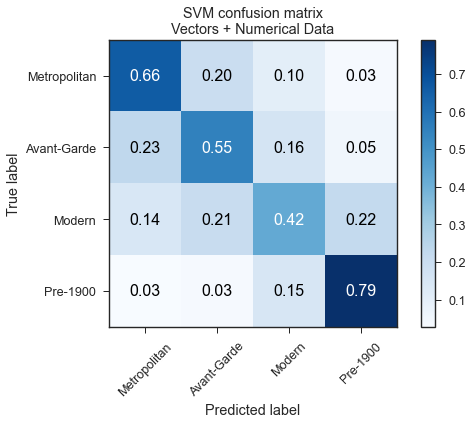

In [88]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_svm_word)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_word_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

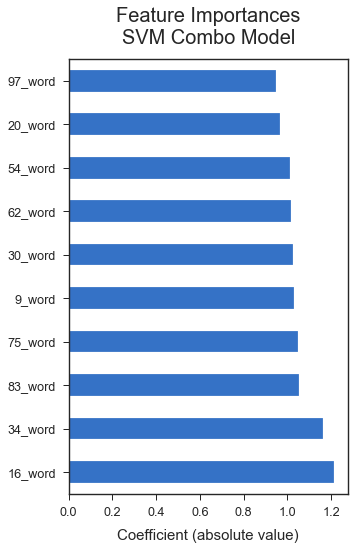

In [216]:
# plot top ten features
svm_features(svm_word, word_train_combo.columns)

In [198]:
from sklearn.ensemble import VotingClassifier

100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


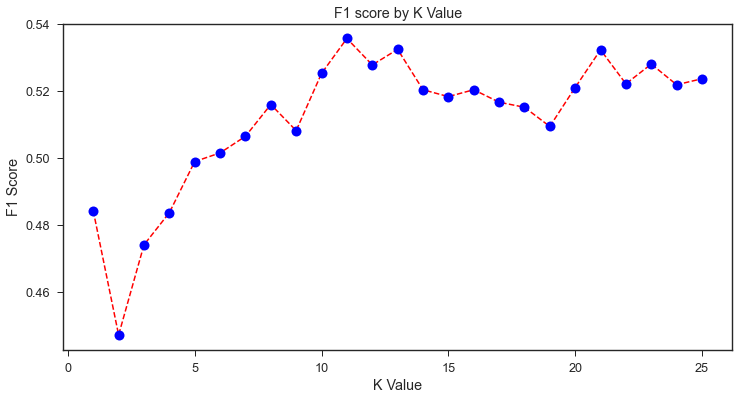

CPU times: user 12 s, sys: 78.8 ms, total: 12.1 s
Wall time: 4.26 s


In [240]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
k_range = list(range(1, 26))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(word_train_combo, y_train)
    y_pred = knn.predict(word_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [241]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(11, 0.535605541772945),
 (13, 0.5323584084513762),
 (21, 0.5322234766001336),
 (23, 0.5279778482262071),
 (12, 0.5277251851723465)]

- *k=5* appears to have the best results, so I'll train a model on that.

In [242]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=11, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(word_train_combo, y_train)

CPU times: user 16.5 ms, sys: 1.52 ms, total: 18 ms
Wall time: 17.2 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='uniform')

In [255]:
%%time

ensemble = VotingClassifier(estimators=[
                            ('nb', benaba_combo),
                            ('knn', knn_combo),
                            ('forest', forest_combo),
                            ('reg', svm_combo), 
                            ('doc', svm_doc_combo), 
                            ('word', svm_word_combo),
                            ('ultra', svm_ultra)
                        ], 
                                     voting='hard')
ensemble.fit(ultra_train_combo, y_train)
ensemble.score(ultra_test_combo, y_test)

CPU times: user 22.5 s, sys: 166 ms, total: 22.7 s
Wall time: 21 s


0.6341689879294337

In [252]:
%%time

train_preds, test_preds = \
    predict(
        ensemble, 
        ultra_train_combo, 
        y_train, 
        ultra_test_combo, 
        y_test, 
        binary=False, 
        to_print=True
)

-----TRAIN-----
Accuracy: 0.7232198142414861
F1 score: 0.7216178153293881

-----TEST-----
Accuracy: 0.6341689879294337
F1 score: 0.6288250186764135

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    pre_1900       0.58      0.54      0.56       239
metropolitan       0.51      0.69      0.59       268
      modern       0.68      0.45      0.54       311
 avant_garde       0.81      0.88      0.84       259

    accuracy                           0.63      1077
   macro avg       0.64      0.64      0.63      1077
weighted avg       0.65      0.63      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[130  77  24   8]
 [ 48 186  24  10]
 [ 43  92 139  37]
 [  3  11  17 228]]
CPU times: user 6.28 s, sys: 90.5 ms, total: 6.37 s
Wall time: 1.38 s


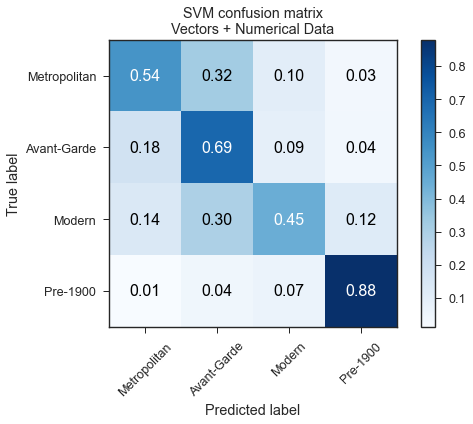

In [253]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_word_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

## Combining document and word vectors

[[go back to the top](#Predicting-Poetic-Movements)]

### Preparing the data
- I'll combine engineered features, document vectors, and word vectors.

In [89]:
# combine dataframes for both train and test data
ultra_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs, word_train_vecs], axis=1)
ultra_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs, word_test_vecs], axis=1)

In [90]:
%%time

# instantiate svm classifiers
svm_ultra_combo = LinearSVC(random_state=1)

# fit them to the training set and evaluate
cv_scores_svm_ultra_combo = cross_val_score(
    svm_ultra_combo, ultra_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_ultra_combo}')
print(f'Average score: {np.mean(cv_scores_svm_ultra_combo)}\n')

------Vectors + Numerical Data-----
All scores: [0.54843362 0.65662044 0.62162566 0.61314552 0.64097682 0.63589362
 0.58891476 0.60028561 0.63918098 0.60879978]
Average score: 0.6153876796268938

CPU times: user 52.7 ms, sys: 7.11 ms, total: 59.8 ms
Wall time: 15 s


In [91]:
%%time

# instantiate the model
svm_ultra = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_ultra.fit(ultra_train_combo, y_train)

CPU times: user 5.45 s, sys: 11.8 ms, total: 5.47 s
Wall time: 5.47 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [ ]:
%%time

# model predictions and printout
train_preds_ultra, test_preds_ultra = \
    predict(svm_ultra, ultra_train_combo, y_train, 
            ultra_test_combo, y_test, binary=False)

In [92]:
%%time

# predict class for the train and test sets
train_ultra_preds = svm_ultra.predict(ultra_train_combo)
test_ultra_preds = svm_ultra.predict(ultra_test_combo)

# print out accuracy and f1 scores for train set
svm_ultra_acc_train = accuracy_score(y_train, train_ultra_preds)
svm_ultra_f1_train = f1_score(y_train, train_ultra_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_ultra_acc_train}')
print(f'F1 score: {svm_ultra_f1_train}')

# print out accuracy and f1 scores for test set
svm_ultra_acc_test = accuracy_score(y_test, test_ultra_preds)
svm_ultra_f1_test = f1_score(y_test, test_ultra_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_ultra_acc_test}')
print(f'F1 score: {svm_ultra_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_ultra_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_ultra_preds))

-----TRAIN-----
Accuracy: 0.7037151702786377
F1 score: 0.7015645664624138

-----TEST-----
Accuracy: 0.6285979572887651
F1 score: 0.6231923869924192

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.59      0.52      0.55       239
 avant_garde       0.50      0.68      0.58       268
      modern       0.66      0.45      0.54       311
    pre_1900       0.80      0.88      0.84       259

    accuracy                           0.63      1077
   macro avg       0.64      0.63      0.63      1077
weighted avg       0.64      0.63      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[125  79  27   8]
 [ 43 182  31  12]
 [ 42  91 141  37]
 [  3  11  16 229]]
CPU times: user 185 ms, sys: 25.8 ms, total: 210 ms
Wall time: 53.8 ms


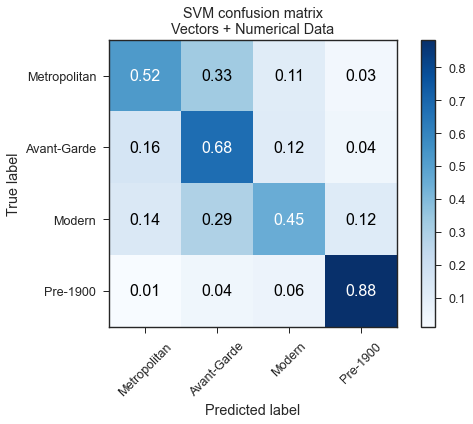

In [93]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_preds_ultra)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_ultra_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [94]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [95]:
doc_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [96]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.5s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [97]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.626178851914006
{'C': 0.01}
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [123]:
param_grid = {
    'C': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]
}

In [124]:
doc_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [133]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.9s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [134]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6267013730269566
{'C': 0.0025}
LinearSVC(C=0.0025, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [136]:
%%time

# instantiate the model
svm_doc = LinearSVC(C=0.0025, random_state=1)

# fit to the training set
svm_doc.fit(doc_train_combo, y_train)

CPU times: user 262 ms, sys: 2.85 ms, total: 264 ms
Wall time: 266 ms


LinearSVC(C=0.0025, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [137]:
%%time

# predict class for the train and test sets
train_doc_preds = svm_doc.predict(doc_train_combo)
test_doc_preds = svm_doc.predict(doc_test_combo)

# print out accuracy and f1 scores for train set
svm_doc_acc_train = accuracy_score(y_train, train_doc_preds)
svm_doc_f1_train = f1_score(y_train, train_doc_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc_acc_train}')
print(f'F1 score: {svm_doc_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc_acc_test = accuracy_score(y_test, test_doc_preds)
svm_doc_f1_test = f1_score(y_test, test_doc_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc_acc_test}')
print(f'F1 score: {svm_doc_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_doc_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_doc_preds))

-----TRAIN-----
Accuracy: 0.6724458204334365
F1 score: 0.6693021517506966

-----TEST-----
Accuracy: 0.6239554317548747
F1 score: 0.6160533190481263

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.57      0.51      0.54       239
 avant_garde       0.55      0.64      0.59       268
      modern       0.60      0.47      0.53       311
    pre_1900       0.75      0.90      0.82       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  70  36  10]
 [ 44 171  42  11]
 [ 47  61 146  57]
 [  2   7  18 232]]
CPU times: user 220 ms, sys: 32.3 ms, total: 252 ms
Wall time: 64.3 ms


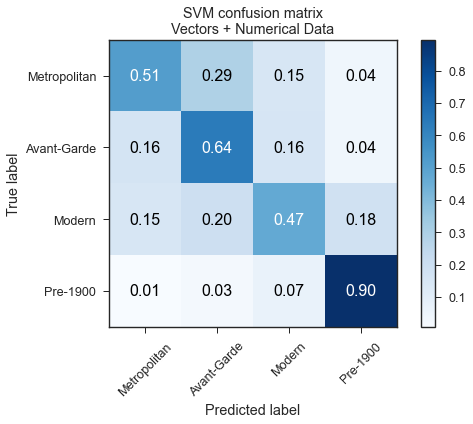

In [138]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_doc_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_doc_tuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

In [219]:
def svm_features(model, col_names, num_features=10, title='Feature Importances'):
    # prettify graph
    plt.figure(figsize=(5,8))
    plt.title(title, fontsize=20, pad=15)
    plt.xlabel('Coefficient (absolute value)', 
               fontsize=15, labelpad=10)

    # plot top ten features
    pd.Series(abs(model.coef_[0]), 
                  index=col_names)\
                  .nlargest(10).plot(kind='barh');

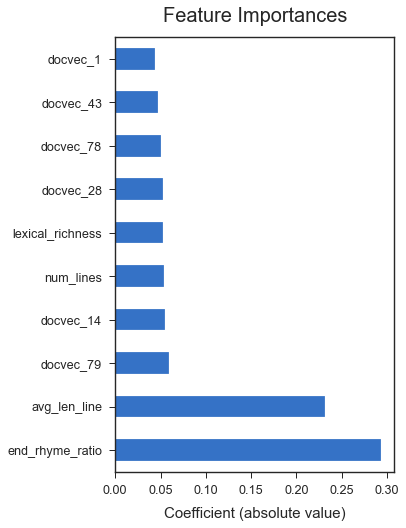

In [220]:
svm_features(svm_doc, doc_train_combo.columns)

In [ ]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc.coef_[0]), 
              index=doc_train_combo.columns).nlargest(10).\
              plot(kind='barh');

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [105]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [106]:
ultra_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [107]:
ultra_grid.fit(ultra_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   55.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [108]:
# examine the best model
print(ultra_grid.best_score_)
print(ultra_grid.best_params_)
print(ultra_grid.best_estimator_)

0.6294314188233476
{'C': 0.01}
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [139]:
param_grid = {
    'C': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]
}

In [140]:
ultra_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [141]:
ultra_grid.fit(ultra_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [142]:
# examine the best model
print(ultra_grid.best_score_)
print(ultra_grid.best_params_)
print(ultra_grid.best_estimator_)

0.6320216819357523
{'C': 0.005}
LinearSVC(C=0.005, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [143]:
%%time

# instantiate the model
svm_ultra = LinearSVC(C=0.005, random_state=1)

# fit to the training set
svm_ultra.fit(ultra_train_combo, y_train)

CPU times: user 727 ms, sys: 4.44 ms, total: 732 ms
Wall time: 734 ms


LinearSVC(C=0.005, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [144]:
%%time

# predict class for the train and test sets
train_ultra_preds = svm_ultra.predict(ultra_train_combo)
test_ultra_preds = svm_ultra.predict(ultra_test_combo)

# print out accuracy and f1 scores for train set
svm_ultra_acc_train = accuracy_score(y_train, train_ultra_preds)
svm_ultra_f1_train = f1_score(y_train, train_ultra_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_ultra_acc_train}')
print(f'F1 score: {svm_ultra_f1_train}')

# print out accuracy and f1 scores for test set
svm_ultra_acc_test = accuracy_score(y_test, test_ultra_preds)
svm_ultra_f1_test = f1_score(y_test, test_ultra_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_ultra_acc_test}')
print(f'F1 score: {svm_ultra_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_ultra_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_ultra_preds))

-----TRAIN-----
Accuracy: 0.6736842105263158
F1 score: 0.6706832094571464

-----TEST-----
Accuracy: 0.617455896007428
F1 score: 0.6047459844371723

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.56      0.53      0.55       239
 avant_garde       0.53      0.70      0.60       268
      modern       0.64      0.38      0.48       311
    pre_1900       0.74      0.90      0.81       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.61      1077
weighted avg       0.62      0.62      0.60      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[127  75  26  11]
 [ 42 187  28  11]
 [ 55  79 119  58]
 [  2  11  14 232]]
CPU times: user 261 ms, sys: 43.3 ms, total: 304 ms
Wall time: 79.3 ms


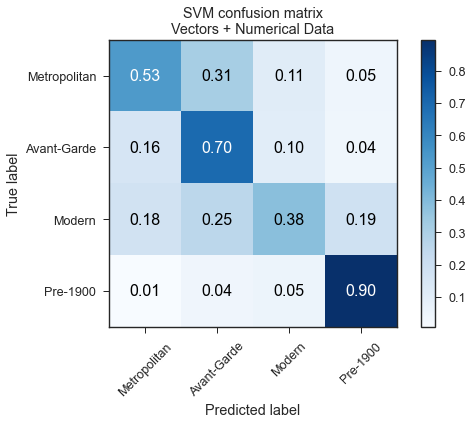

In [145]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_ultra_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_ultra_tuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

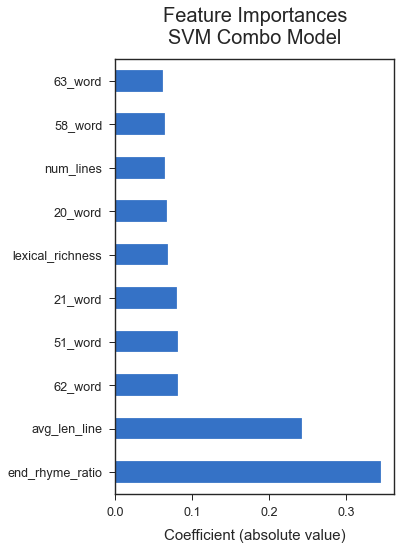

In [217]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_ultra.coef_[0]), 
              index=ultra_train_combo.columns).nlargest(10).\
              plot(kind='barh');

## Neural Nets

[[go back to the top](#Predicting-Poetic-Movements)]



In [116]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

Using TensorFlow backend.


In [164]:
%%time

# vectorize poems into a 2D integer tensor using Keras Tokenizer
# only fit on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.string_processed)

# convert train and test sets to vectors of word indexes
train_sequences = tokenizer.texts_to_sequences(
    X_train.string_processed) 
test_sequences = tokenizer.texts_to_sequences(
    X_test.string_processed)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n')

Found 43072 unique tokens.
CPU times: user 1.16 s, sys: 82.3 ms, total: 1.25 s
Wall time: 1.34 s


In [118]:
max([len(poem) for poem in train_data])

7609

In [165]:
# convert movements to numerical values
le = LabelEncoder()
le_train = le.fit_transform(y_train)
le_test = le.transform(y_test)

In [180]:
# only use first 1000 words
# most poems are shorter than this anyway
max_seq_len = 1000

# use all words
max_num_words = len(word_index)

# number of dimensions in pretrained word embeddings
embedding_dim = 300

In [181]:

# convert to sequences to be fed into neural network
# initial padding of 0s, until vector is of size set earlier
train_data_padded = pad_sequences(train_sequences, maxlen=max_seq_len)
test_data_padded = pad_sequences(test_sequences, maxlen=max_seq_len)
train_labels = to_categorical(np.asarray(le_train))
test_labels = to_categorical(np.asarray(le_test))

# split training data into training and validation sets
indices = np.arange(train_data_padded.shape[0])
np.random.shuffle(indices)
trainvalid_data = train_data_padded[indices]
trainvalid_labels = train_labels[indices]
num_validation_samples = int(0.2 * trainvalid_data.shape[0])
X_train_nn = trainvalid_data[:-num_validation_samples]
y_train_nn = trainvalid_labels[:-num_validation_samples]
X_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

In [182]:
%%time

embed_path = '~/Documents/word_embeddings/glove6b/glove.6B.300d.txt'

# build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(os.path.expanduser(embed_path)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], 
                           dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors in GloVe embeddings.\n')

# prepare embedding matrix
# rows are the words from word_index
# columns are the embeddings of that word from glove
num_words = min(max_num_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i > max_num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into Embedding layer
# set trainable = False to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_seq_len,
                            trainable=False)

Found 400000 word vectors in GloVe embeddings.

CPU times: user 24.8 s, sys: 819 ms, total: 25.7 s
Wall time: 25.7 s


In [193]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnn_model = Sequential()
rnn_model.add(embedding_layer)
rnn_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(4, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])
print('Training the RNN')

rnn_model.fit(X_train_nn, y_train_nn,
          batch_size=32,
          epochs=5,
          validation_data=(X_val, y_val))
score, acc = rnn_model.evaluate(test_data_padded, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
Train on 2584 samples, validate on 646 samples
Epoch 1/5
2584/2584 [==============================] - 94s 37ms/step - loss: 1.3533 - categorical_accuracy: 0.3220 - val_loss: 1.2557 - val_categorical_accuracy: 0.4226
Epoch 2/5
2584/2584 [==============================] - 103s 40ms/step - loss: 1.2432 - categorical_accuracy: 0.4361 - val_loss: 1.2158 - val_categorical_accuracy: 0.4412
Epoch 3/5
2584/2584 [==============================] - 101s 39ms/step - loss: 1.1704 - categorical_accuracy: 0.4834 - val_loss: 1.1563 - val_categorical_accuracy: 0.4985
Epoch 4/5
2584/2584 [==============================] - 107s 42ms/step - loss: 1.1123 - categorical_accuracy: 0.5147 - val_loss: 1.1430 - val_categorical_accuracy: 0.4969
Epoch 5/5
1077/1077 [==============================] - 12s 11ms/step
Test accuracy with RNN: 0.47910863516667207


In [162]:
y_val

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [194]:
rnn_preds = rnn_model.predict_classes(test_data_padded)
rnn_preds[:5]

array([2, 2, 2, 2, 2])

In [195]:
rnn_preds_labeled = le.inverse_transform(rnn_preds)
rnn_preds_labeled[:5]

array(['modern', 'modern', 'modern', 'modern', 'modern'], dtype=object)

In [196]:
y_test[:5]

859     metropolitan
2266          modern
3326        pre_1900
2646          modern
1557          modern
Name: movement, dtype: object

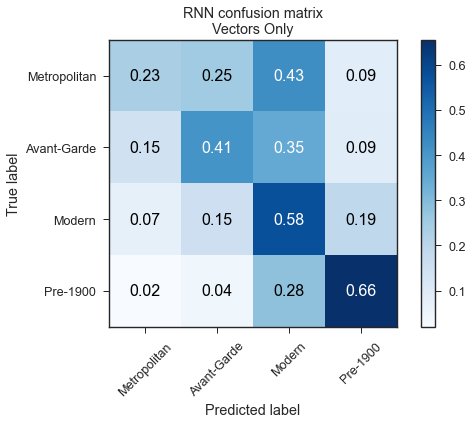

In [197]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, rnn_preds_labeled)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='RNN confusion matrix\nVectors Only',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rnn_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**